In [1]:
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from Golgi import Golgi

In [2]:
# Instantiation of the cell templates
cells = [Golgi(1, morpho=1), Golgi(2, morpho=2)]

# Fixed time step only
Fixed_step = h.CVode()
Fixed_step.active(0)

# Activate the multisplit to use half of cores available
cpu = multiprocessing.cpu_count()//2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(cpu,1)
p.multisplit(1)


5394 lines read

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


0.0

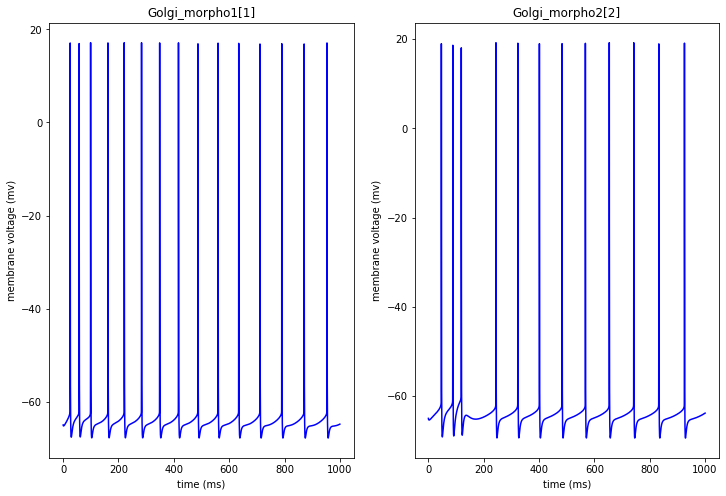

In [3]:
########## Spontaneous Generation ##########

# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.tstop = 1000  # time to stop the entire simulation (ms)
h.v_init = -65  # initial membrane potential (mV)

plt.figure(figsize=(12, 8))
for j, cell in enumerate(cells):
    time = h.Vector()
    time.record(h._ref_t)

    #Initialization 
    h.finitialize()
    h.run()

    # Plot the results
    plt.subplot(1, len(cells), j + 1)
    plt.title(str(cell))
    plt.plot(np.array(time), np.array(cell.vm), 'b')
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")


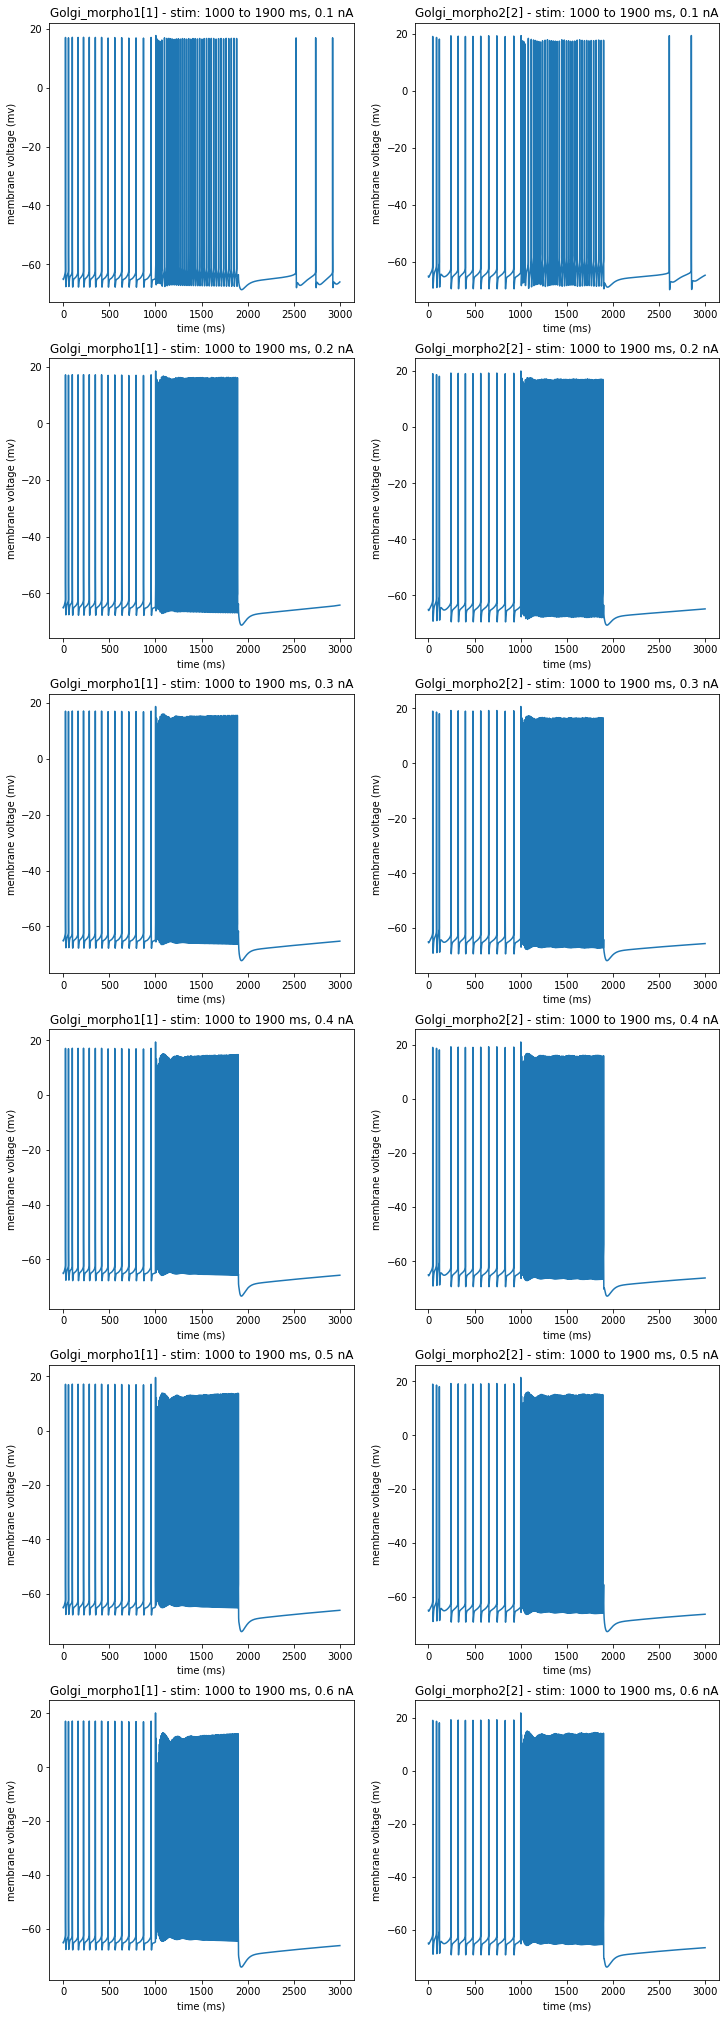

In [4]:
########## Current Testing ##########

# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.tstop = 3000  # time to stop the entire simulation (ms)
h.v_init = -65  # initial membrane potential (mV)
   
stimdata = [
    [1000, 900, 0.1],  # delay, duration, amplitude
    [1000, 900, 0.2],
    [1000, 900, 0.3],
    [1000, 900, 0.4],
    [1000, 900, 0.5],
    [1000, 900, 0.6],
]

plt.figure(figsize=(12, 6*len(stimdata)))
for j, cell in enumerate(cells):
    for i, (delay, duration, amplitude) in enumerate(stimdata):
        stim = [h.IClamp(0.5, sec=cell.soma[0])]
        stim[0].delay = delay
        stim[0].dur = duration
        stim[0].amp = amplitude

        time = h.Vector()
        time.record(h._ref_t)

        #Initialization 
        h.finitialize()
        h.run()

        # Plot the results
        plt.subplot(len(stimdata), len(cells), i*len(cells) + j + 1)
        plt.title(f"{cell} - stim: {delay} to {delay+duration} ms, {amplitude} nA")
        plt.plot(np.array(time), np.array(cell.vm))
        plt.xlabel("time (ms)")
        plt.ylabel("membrane voltage (mv)")

        del stim  # make sure these are all disconnected

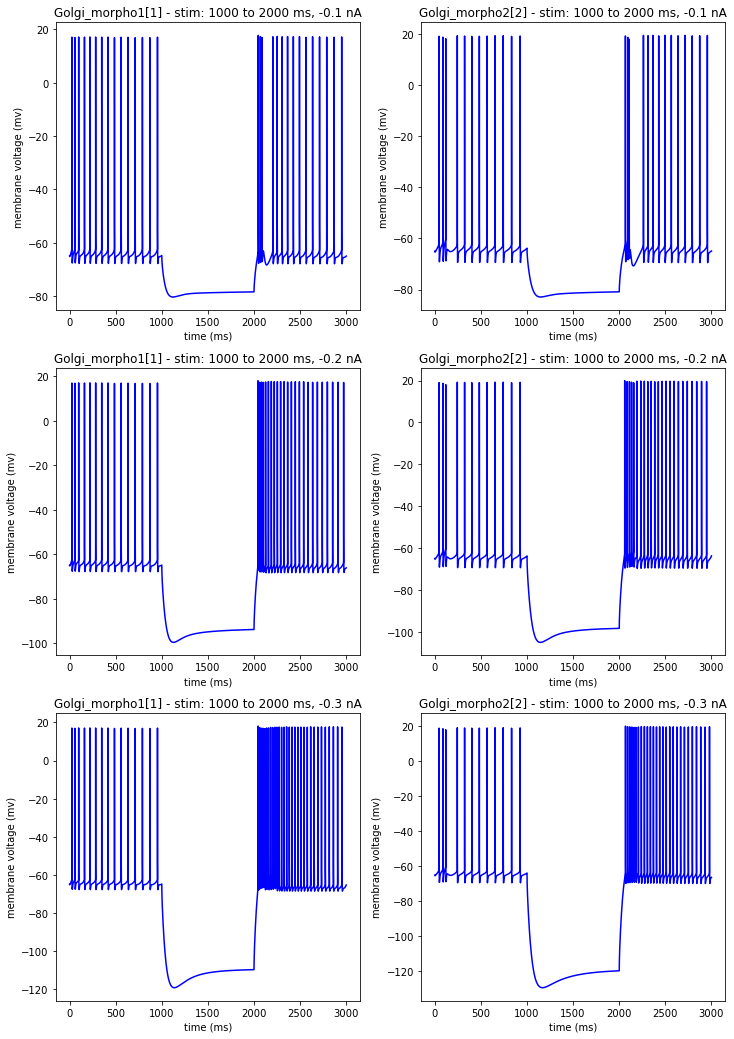

In [5]:
########## Negative Current Testing ##########

# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.tstop = 3000  # time to stop the entire simulation (ms)
h.v_init = -65  # initial membrane potential (mV)

stimdata = [
    [1000, 1000, -0.1],  # delay, duration, amplitude
    [1000, 1000, -0.2],
    [1000, 1000, -0.3],
]

plt.figure(figsize=(12, 6*len(stimdata)))
for j, cell in enumerate(cells):
    for i, (delay, duration, amplitude) in enumerate(stimdata):
        stim = [h.IClamp(0.5, sec=cell.soma[0])]
        stim[0].delay = delay
        stim[0].dur = duration
        stim[0].amp = amplitude

        time = h.Vector()
        time.record(h._ref_t)

        #Initialization 
        h.finitialize()
        h.run()

        # Plot the results
        plt.subplot(len(stimdata), len(cells), i*len(cells) + j + 1)
        plt.title(f"{cell} - stim: {delay} to {delay+duration} ms, {amplitude} nA")
        plt.plot(np.array(time), np.array(cell.vm), 'b')
        plt.xlabel("time (ms)")
        plt.ylabel("membrane voltage (mv)")

        del stim  # make sure these are all disconnected

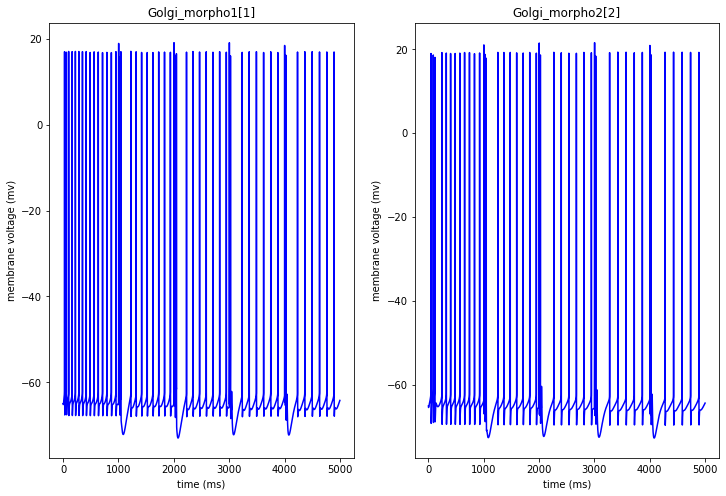

In [7]:
########### Synaptic activity, Parallel fibers, ascending axons, mossy fibers and inhibition ##########
import random as rnd
seed = 123456
rnd.seed(seed)
h.use_mcell_ran4(1)
h.mcell_ran4_init(seed)

# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.tstop = 5000  # time to stop the entire simulation (ms)
h.v_init = -65  # initial membrane potential (mV)

# Number of spikes, interval, starting moment, delay factor to activate two different types of synapses in two different moments, presence of noise
# See the defaults in create_syn_stims()
synapse_data_pf = {'number': 5, 'interval': 10, 'start': 1000}
synapse_data_mf = {'number': 5, 'interval': 10, 'start': 1000}
synapse_data_aa = {'number': 5, 'interval': 10, 'start': 1000}

def create_syn_stims(synapses, number=5, interval=10, start=1000, delay=0, noise=0):
    stims = []
    ncs = []
    totalstim = int(h.tstop / start)
    for j in range(totalstim):
        s = h.NetStim()
        s.interval = interval
        s.number = number
        s.noise = noise
        s.start = start * (totalstim - j) + delay
        stims.append(s)
        ncs.extend(h.NetCon(s, syn.input, 0, 0.1, 1) for syn in synapses)
    return stims, ncs


plt.figure(figsize=(12, 8))
for j, cell in enumerate(cells):
    # Create the synapses (max used in the paper: 89, 20, 20)
    # Not included: inhibitory synapses (up to 20 in the paper)
    cell.createsyn(pf_n=89, mf_n=0, aa_n=0)
    spk_stim_pf, spk_nc_pfsyn = create_syn_stims(cell.L_PF, **synapse_data_pf)
    spk_stim_mf, spk_nc_mfsyn = create_syn_stims(cell.L_MF+cell.L_MF_NMDA_B, **synapse_data_mf)
    spk_stim_aa, spk_nc_aasyn = create_syn_stims(cell.L_AA+cell.L_AA_NMDA_B, **synapse_data_aa)

    time = h.Vector()
    time.record(h._ref_t)

    #Initialization 
    h.finitialize()
    h.run()

    # Plot the results
    plt.subplot(1, len(cells), j + 1)
    plt.title(str(cell))
    plt.plot(np.array(time), np.array(cell.vm), 'b')
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

    # np.savetxt(f'04_trace_indiv_syn_pf_{pf_n}_mf_{mf_n}_aa_{aa_n}_inib_{inib_n}_morpho_1.txt',
    #            np.column_stack((time, cell.vm)), delimiter=',')

    del spk_stim_pf, spk_nc_pfsyn, spk_stim_mf, spk_nc_mfsyn, spk_stim_aa, spk_nc_aasyn  # make sure these are all disconnected